In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sksurv
import sksurv.datasets
from sksurv.nonparametric import kaplan_meier_estimator

# Charger le dataset veterans_lung_cancer
X, y = sksurv.datasets.load_veterans_lung_cancer()

print("Shape du dataset X:", X.shape)
print("Colonnes disponibles:", X.columns.tolist())
print("Premières lignes de X:")
print(X.head())
print("\nInformations sur y (survie):")
print(y[:5])
print(f"Type de y: {type(y)}")
print(f"Structure de y: {y.dtype}")



Shape du dataset X: (137, 6)
Colonnes disponibles: ['Age_in_years', 'Celltype', 'Karnofsky_score', 'Months_from_Diagnosis', 'Prior_therapy', 'Treatment']
Premières lignes de X:
   Age_in_years  Celltype  Karnofsky_score  Months_from_Diagnosis  \
0          69.0  squamous             60.0                    7.0   
1          64.0  squamous             70.0                    5.0   
2          38.0  squamous             60.0                    3.0   
3          63.0  squamous             60.0                    9.0   
4          65.0  squamous             70.0                   11.0   

  Prior_therapy Treatment  
0            no  standard  
1           yes  standard  
2            no  standard  
3           yes  standard  
4           yes  standard  

Informations sur y (survie):
[( True,  72.) ( True, 411.) ( True, 228.) ( True, 126.) ( True, 118.)]
Type de y: <class 'numpy.ndarray'>
Structure de y: [('Status', '?'), ('Survival_in_days', '<f8')]


In [73]:
# Ajuster l'estimateur de Kaplan-Meier
# Pour veterans_lung_cancer, les colonnes sont 'Status' et 'Survival_in_days'
time, survival_prob = kaplan_meier_estimator(y['Status'], y['Survival_in_days'])

print(f"Nombre de points temporels: {len(time)}")
print(f"Probabilité de survie initiale: {survival_prob[0]:.4f}")
print(f"Probabilité de survie finale: {survival_prob[-1]:.4f}")
print(f"Temps minimum: {time[0]:.2f} jours")
print(f"Temps maximum: {time[-1]:.2f} jours")
print(f"Nombre total de patients: {len(y)}")
print(f"Événements observés (décès): {np.sum(y['Status'])}")
print(f"Censures: {len(y) - np.sum(y['Status'])}")


Nombre de points temporels: 101
Probabilité de survie initiale: 0.9854
Probabilité de survie finale: 0.0000
Temps minimum: 1.00 jours
Temps maximum: 999.00 jours
Nombre total de patients: 137
Événements observés (décès): 128
Censures: 9


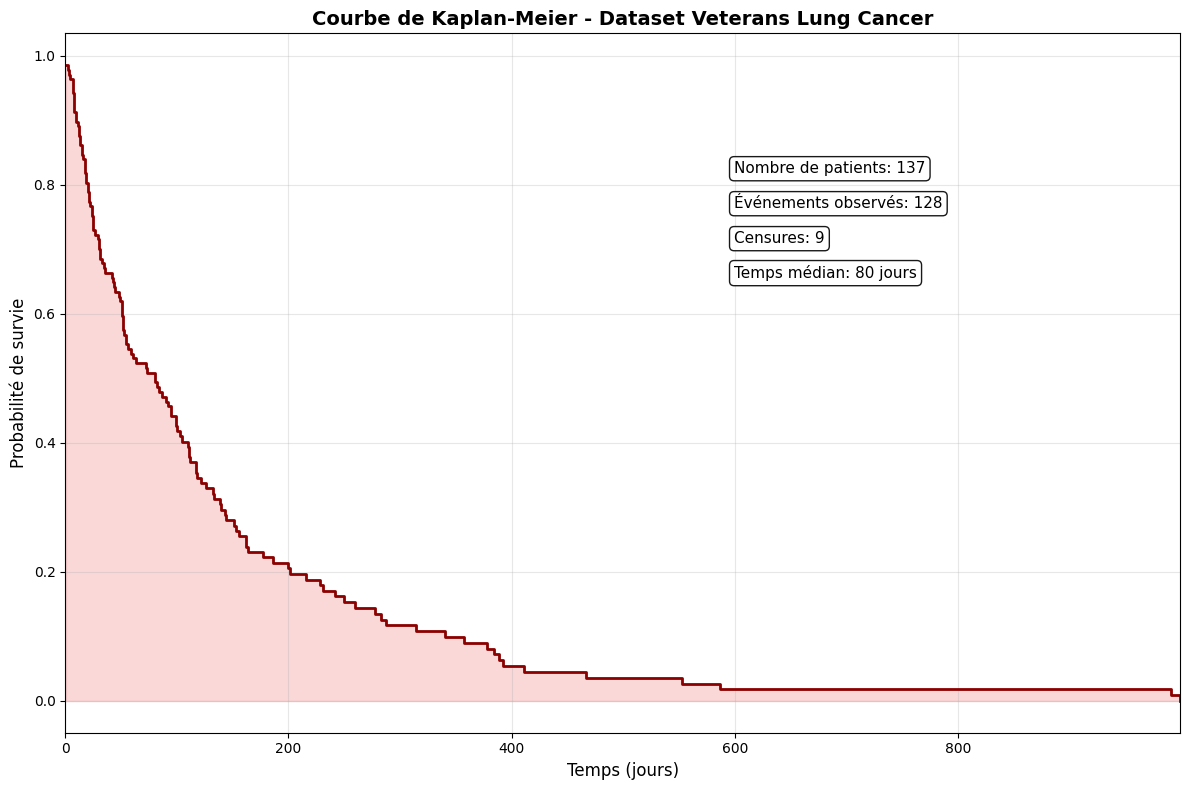

In [74]:
# Afficher la courbe de Kaplan-Meier
plt.figure(figsize=(12, 8))
plt.step(time, survival_prob, where="post", linewidth=2, color='darkred')
plt.fill_between(time, survival_prob, step="post", alpha=0.3, color='lightcoral')

plt.xlabel('Temps (jours)', fontsize=12)
plt.ylabel('Probabilité de survie', fontsize=12)
plt.title('Courbe de Kaplan-Meier - Dataset Veterans Lung Cancer', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xlim(0, time[-1])

# Ajouter des informations statistiques
plt.text(0.6, 0.8, f'Nombre de patients: {len(y)}', 
         transform=plt.gca().transAxes, fontsize=11,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9))
plt.text(0.6, 0.75, f'Événements observés: {np.sum(y["Status"])}', 
         transform=plt.gca().transAxes, fontsize=11,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9))
plt.text(0.6, 0.7, f'Censures: {len(y) - np.sum(y["Status"])}', 
         transform=plt.gca().transAxes, fontsize=11,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9))
plt.text(0.6, 0.65, f'Temps médian: {time[np.where(survival_prob <= 0.5)[0][0]]:.0f} jours', 
         transform=plt.gca().transAxes, fontsize=11,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9))

plt.tight_layout()
plt.show()


In [75]:
X['Celltype'] = X['Celltype'].astype(bool).astype(int)
X['Treatment'] = X['Treatment'].astype(bool).astype(int)
X['Prior_therapy'] = X['Prior_therapy'].astype(bool).astype(int)

In [76]:
X

,Age_in_years,Celltype,Karnofsky_score,Months_from_Diagnosis,Prior_therapy,Treatment
0,69.0,1,60.0,7.0,1,1
1,64.0,1,70.0,5.0,1,1
2,38.0,1,60.0,3.0,1,1
3,63.0,1,60.0,9.0,1,1
4,65.0,1,70.0,11.0,1,1
...,...,...,...,...,...,...
132,65.0,1,75.0,1.0,1,1
133,64.0,1,60.0,5.0,1,1
134,67.0,1,70.0,18.0,1,1
135,65.0,1,80.0,4.0,1,1


In [79]:
y_df=pd.DataFrame(y)
X['duration']=y_df['Survival_in_days']

In [78]:
y_df

,Status,Survival_in_days
0,True,72.0
1,True,411.0
2,True,228.0
3,True,126.0
4,True,118.0
...,...,...
132,True,133.0
133,True,111.0
134,True,231.0
135,True,378.0


In [44]:
print(X.corr())

                       Age_in_years  Celltype  Karnofsky_score  \
Age_in_years               1.000000       NaN        -0.094985   
Celltype                        NaN       NaN              NaN   
Karnofsky_score           -0.094985       NaN         1.000000   
Months_from_Diagnosis     -0.033422       NaN        -0.183712   
Prior_therapy                   NaN       NaN              NaN   
Treatment                       NaN       NaN              NaN   
Censored                   0.072258       NaN        -0.165087   
duration                  -0.068327       NaN         0.381601   

                       Months_from_Diagnosis  Prior_therapy  Treatment  \
Age_in_years                       -0.033422            NaN        NaN   
Celltype                                 NaN            NaN        NaN   
Karnofsky_score                    -0.183712            NaN        NaN   
Months_from_Diagnosis               1.000000            NaN        NaN   
Prior_therapy                      

In [54]:
X

,Age_in_years,Celltype,Karnofsky_score,Months_from_Diagnosis,Prior_therapy,Treatment,Censored,duration
0,69.0,1,60.0,7.0,1,1,1,72.0
1,64.0,1,70.0,5.0,1,1,1,411.0
2,38.0,1,60.0,3.0,1,1,1,228.0
3,63.0,1,60.0,9.0,1,1,1,126.0
4,65.0,1,70.0,11.0,1,1,1,118.0
...,...,...,...,...,...,...,...,...
132,65.0,1,75.0,1.0,1,1,1,133.0
133,64.0,1,60.0,5.0,1,1,1,111.0
134,67.0,1,70.0,18.0,1,1,1,231.0
135,65.0,1,80.0,4.0,1,1,1,378.0


In [82]:
from lifelines import CoxPHFitter

#data_x, data_y = load_veterans_lung_cancer()

cph = CoxPHFitter()
cph.fit(X,event_col=y_df["Status"].astype(bool))  # ici event_col = censure
cph.print_summary()


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().